In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from setup_utils import setup_db_connection
engine = setup_db_connection()

In [23]:
# Add a parameter for the number of distinct subject_ids to retrieve
num_subjects = 50

vital_query = f"""
SELECT v.*
FROM mimiciv_derived.vitalsign v
WHERE v.subject_id IN (
    SELECT DISTINCT subject_id
    FROM mimiciv_derived.vitalsign
    LIMIT 100 -- Replace 100 with your desired limit
);"""
vitals_df = pd.read_sql_query(vital_query, engine)

In [24]:
vitals_df.head()

,subject_id,stay_id,charttime,heart_rate,sbp,dbp,mbp,sbp_ni,dbp_ni,mbp_ni,resp_rate,temperature,temperature_site,spo2,glucose
0,10004113,39774222,2173-03-20 20:00:00,91.0,124.0,76.0,93.0,NaN,NaN,NaN,15.0,37.06,Oral,99.0,NaN
1,10004113,39774222,2173-03-20 20:20:00,86.0,NaN,NaN,NaN,NaN,NaN,NaN,19.0,NaN,None,NaN,NaN
2,10004113,39774222,2173-03-20 20:21:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,100.0,NaN
3,10004113,39774222,2173-03-20 20:24:00,NaN,121.0,67.0,85.0,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
4,10004113,39774222,2173-03-20 21:00:00,89.0,122.0,71.0,87.0,NaN,NaN,NaN,22.0,NaN,None,100.0,NaN


In [25]:
vital_cols = ['heart_rate', 'sbp', 'dbp', 'mbp', 'resp_rate', 'temperature', 'spo2']
vitals_df['charttime'] = pd.to_datetime(vitals_df['charttime'])
vitals_df.set_index('charttime', inplace=True)

In [39]:
daily_vitals = vitals_df[vital_cols].resample('D').mean().dropna(subset=vital_cols).reset_index()
weekly_vitals = vitals_df[vital_cols].resample('W').mean().dropna(subset=vital_cols).reset_index()
monthly_vitals = vitals_df[vital_cols].resample('ME').mean().dropna(subset=vital_cols).reset_index()

In [ ]:
def plot_vitals_comparison(daily, weekly, monthly, vital_cols):
    """
    Plots Daily, Weekly, and Monthly vitals for all columns in vital_cols.
    """
    plt.figure(figsize=(15, 25))  # Adjust figure size
    plt.suptitle('Vitals Over Time (Combined Plots)', fontsize=16, y=0.98)  # Added `y` for better spacing

    # Colors and styles for readability
    styles = {
        'daily': {'color': 'blue', 'label_suffix': 'Daily', 'linestyle': '-'},
        'weekly': {'color': 'orange', 'label_suffix': 'Weekly', 'linestyle': '--'},
        'monthly': {'color': 'green', 'label_suffix': 'Monthly', 'linestyle': ':'},
    }

    # Loop through each vital column
    for i, col in enumerate(vital_cols):
        # Create a subplot
        ax = plt.subplot(len(vital_cols), 1, i + 1)

        # Define common plot lines to avoid repetition
        for key, data in zip(['daily', 'weekly', 'monthly'], [daily, weekly, monthly]):
            plt.plot(
                data['charttime'],
                data[col],
                label=f"{styles[key]['label_suffix']} {col}",
                color=styles[key]['color'],
                linestyle=styles[key]['linestyle']
            )

        # Titles and labels for each subplot
        ax.set_title(f'{col} Over Time', fontsize=12)  # Define font size explicitly
        ax.set_xlabel('Date')
        ax.set_ylabel(col)
        ax.legend()

    # Improved layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])  # Define a padding area for title
    plt.show()

# plot_vitals_comparison(daily_vitals, weekly_vitals, monthly_vitals, vital_cols)

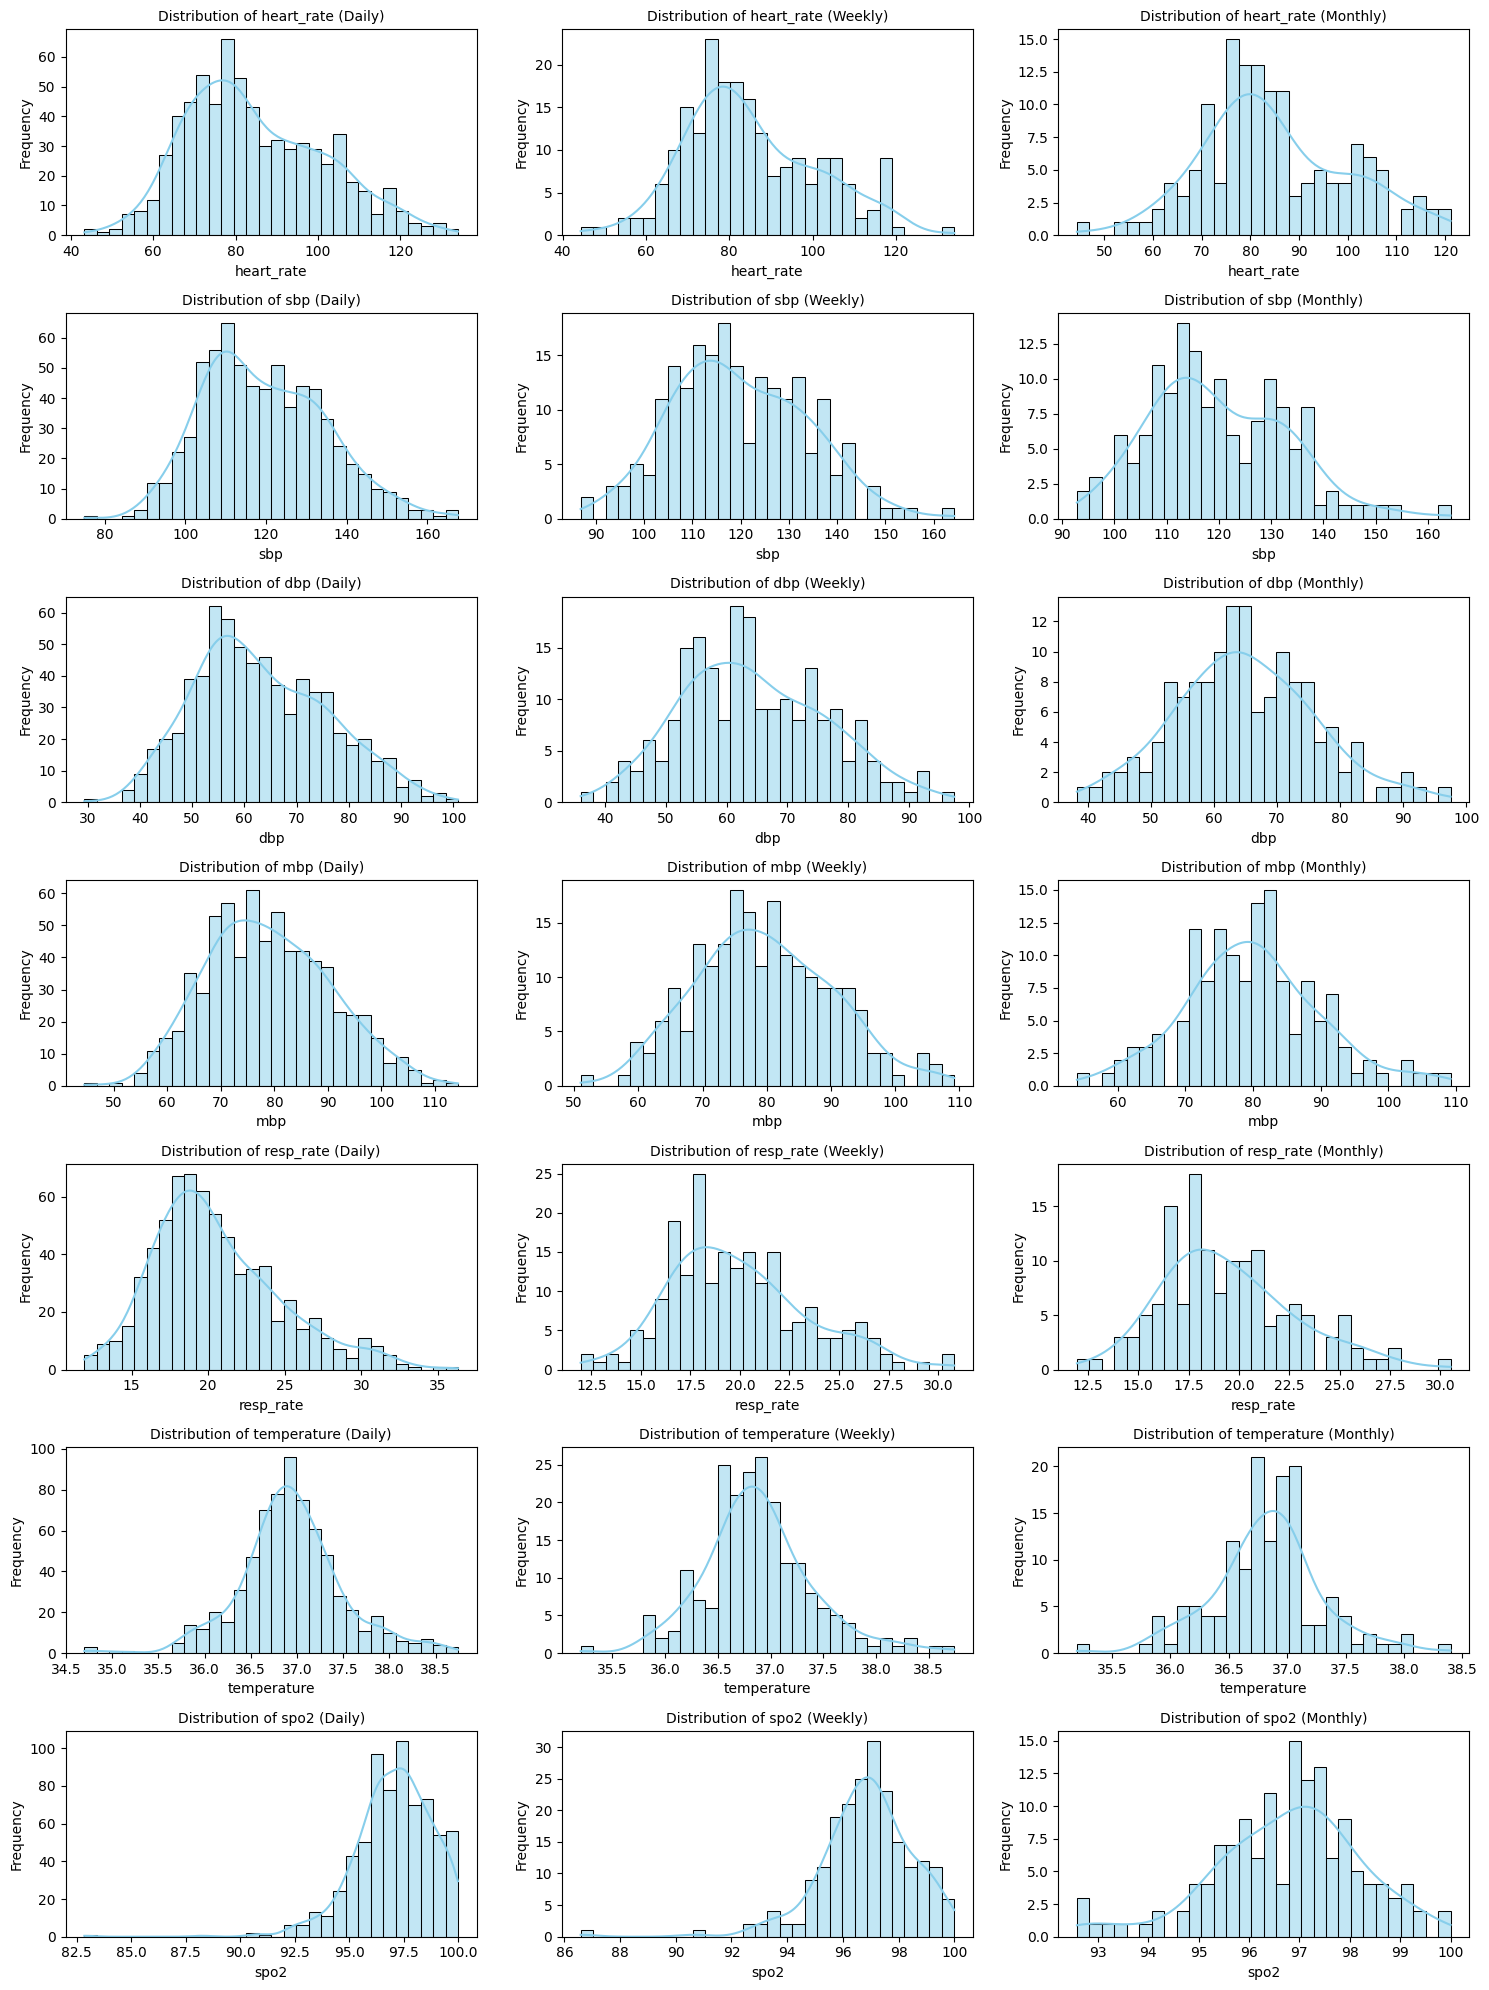

In [34]:
def plot_vital_distributions(daily, weekly, monthly, vital_cols):
    """
    Shows distributions of vitals over different resampling periods (daily, weekly, monthly).
    """
    data_frames = {'Daily': daily, 'Weekly': weekly, 'Monthly': monthly}
    plt.figure(figsize=(15, 20))

    for i, col in enumerate(vital_cols):
        for j, (period, df) in enumerate(data_frames.items()):
            ax = plt.subplot(len(vital_cols), len(data_frames), i * len(data_frames) + j + 1)
            sns.histplot(df[col], kde=True, ax=ax, bins=30, color='skyblue')
            ax.set_title(f'Distribution of {col} ({period})', fontsize=10)
            ax.set_xlabel(col)
            ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

plot_vital_distributions(daily_vitals, weekly_vitals, monthly_vitals, vital_cols)

In [ ]:
def remove_outliers_iqr(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

In [40]:
# Removing outliers from monthly_vitals
daily_vitals_cleaned = remove_outliers_iqr(daily_vitals.copy(), vital_cols)
weekly_vitals_cleaned = remove_outliers_iqr(weekly_vitals.copy(), vital_cols)
monthly_vitals_cleaned = remove_outliers_iqr(monthly_vitals.copy(), vital_cols)

In [45]:
def compare_distributions(original_df, cleaned_df, vital_cols, title_prefix="Monthly", figsize=(15, 20)):
    """
    Compares the distributions of vital columns before and after cleaning for outliers.
    Args:
        original_df (DataFrame): The original dataframe before cleaning.
        cleaned_df (DataFrame): The cleaned dataframe after outlier removal.
        vital_cols (list): List of vital column names to compare.
        title_prefix (str): Prefix for the title (e.g., "Daily", "Weekly", "Monthly").
        figsize (tuple): Size of the plot figure.

    Returns:
        None: Displays a comparison plot of distributions with text output and difference visualizations.
    """
    # Compute and display summary statistics
    for col in vital_cols:
        print(f"\n=== {col} Statistics ({title_prefix}) ===")
        print(f"Original {title_prefix} Mean: {original_df[col].mean():.2f}, Std Dev: {original_df[col].std():.2f}")
        print(f"Cleaned {title_prefix} Mean: {cleaned_df[col].mean():.2f}, Std Dev: {cleaned_df[col].std():.2f}")
        print(f"Reduction in Rows for {col}: {len(original_df) - len(cleaned_df)}")

    # Create a difference DataFrame between original and cleaned data for visualization
    diff_df = original_df[vital_cols].describe() - cleaned_df[vital_cols].describe()

    # Plot distributions before and after cleaning
    data_frames = {f'Original {title_prefix}': original_df, f'Cleaned {title_prefix}': cleaned_df}
    plt.figure(figsize=figsize)

    for i, col in enumerate(vital_cols):
        for j, (period, df) in enumerate(data_frames.items()):
            ax = plt.subplot(len(vital_cols), len(data_frames), i * len(data_frames) + j + 1)
            sns.histplot(df[col], kde=True, ax=ax, bins=30, color='skyblue' if "Original" in period else 'green')
            ax.set_title(f'Distribution of {col} ({period})', fontsize=10)
            ax.set_xlabel(col)
            ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # Visualize differences in summary metrics
    diff_df.loc[['mean', 'std', '25%', '50%', '75%']].plot(kind='bar', figsize=(10, 6), title="Difference in Metrics After Cleaning")
    plt.ylabel("Difference")
    plt.xlabel("Statistic")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


=== heart_rate Statistics (Daily) ===
Original Daily Mean: 84.75, Std Dev: 16.77
Cleaned Daily Mean: 84.44, Std Dev: 16.54
Reduction in Rows for heart_rate: 65

=== sbp Statistics (Daily) ===
Original Daily Mean: 119.60, Std Dev: 15.17
Cleaned Daily Mean: 119.14, Std Dev: 14.25
Reduction in Rows for sbp: 65

=== dbp Statistics (Daily) ===
Original Daily Mean: 63.27, Std Dev: 12.68
Cleaned Daily Mean: 63.15, Std Dev: 12.50
Reduction in Rows for dbp: 65

=== mbp Statistics (Daily) ===
Original Daily Mean: 78.97, Std Dev: 11.52
Cleaned Daily Mean: 78.75, Std Dev: 11.16
Reduction in Rows for mbp: 65

=== resp_rate Statistics (Daily) ===
Original Daily Mean: 20.58, Std Dev: 4.17
Cleaned Daily Mean: 20.19, Std Dev: 3.82
Reduction in Rows for resp_rate: 65

=== temperature Statistics (Daily) ===
Original Daily Mean: 36.94, Std Dev: 0.56
Cleaned Daily Mean: 36.92, Std Dev: 0.46
Reduction in Rows for temperature: 65

=== spo2 Statistics (Daily) ===
Original Daily Mean: 97.06, Std Dev: 1.81
Cle

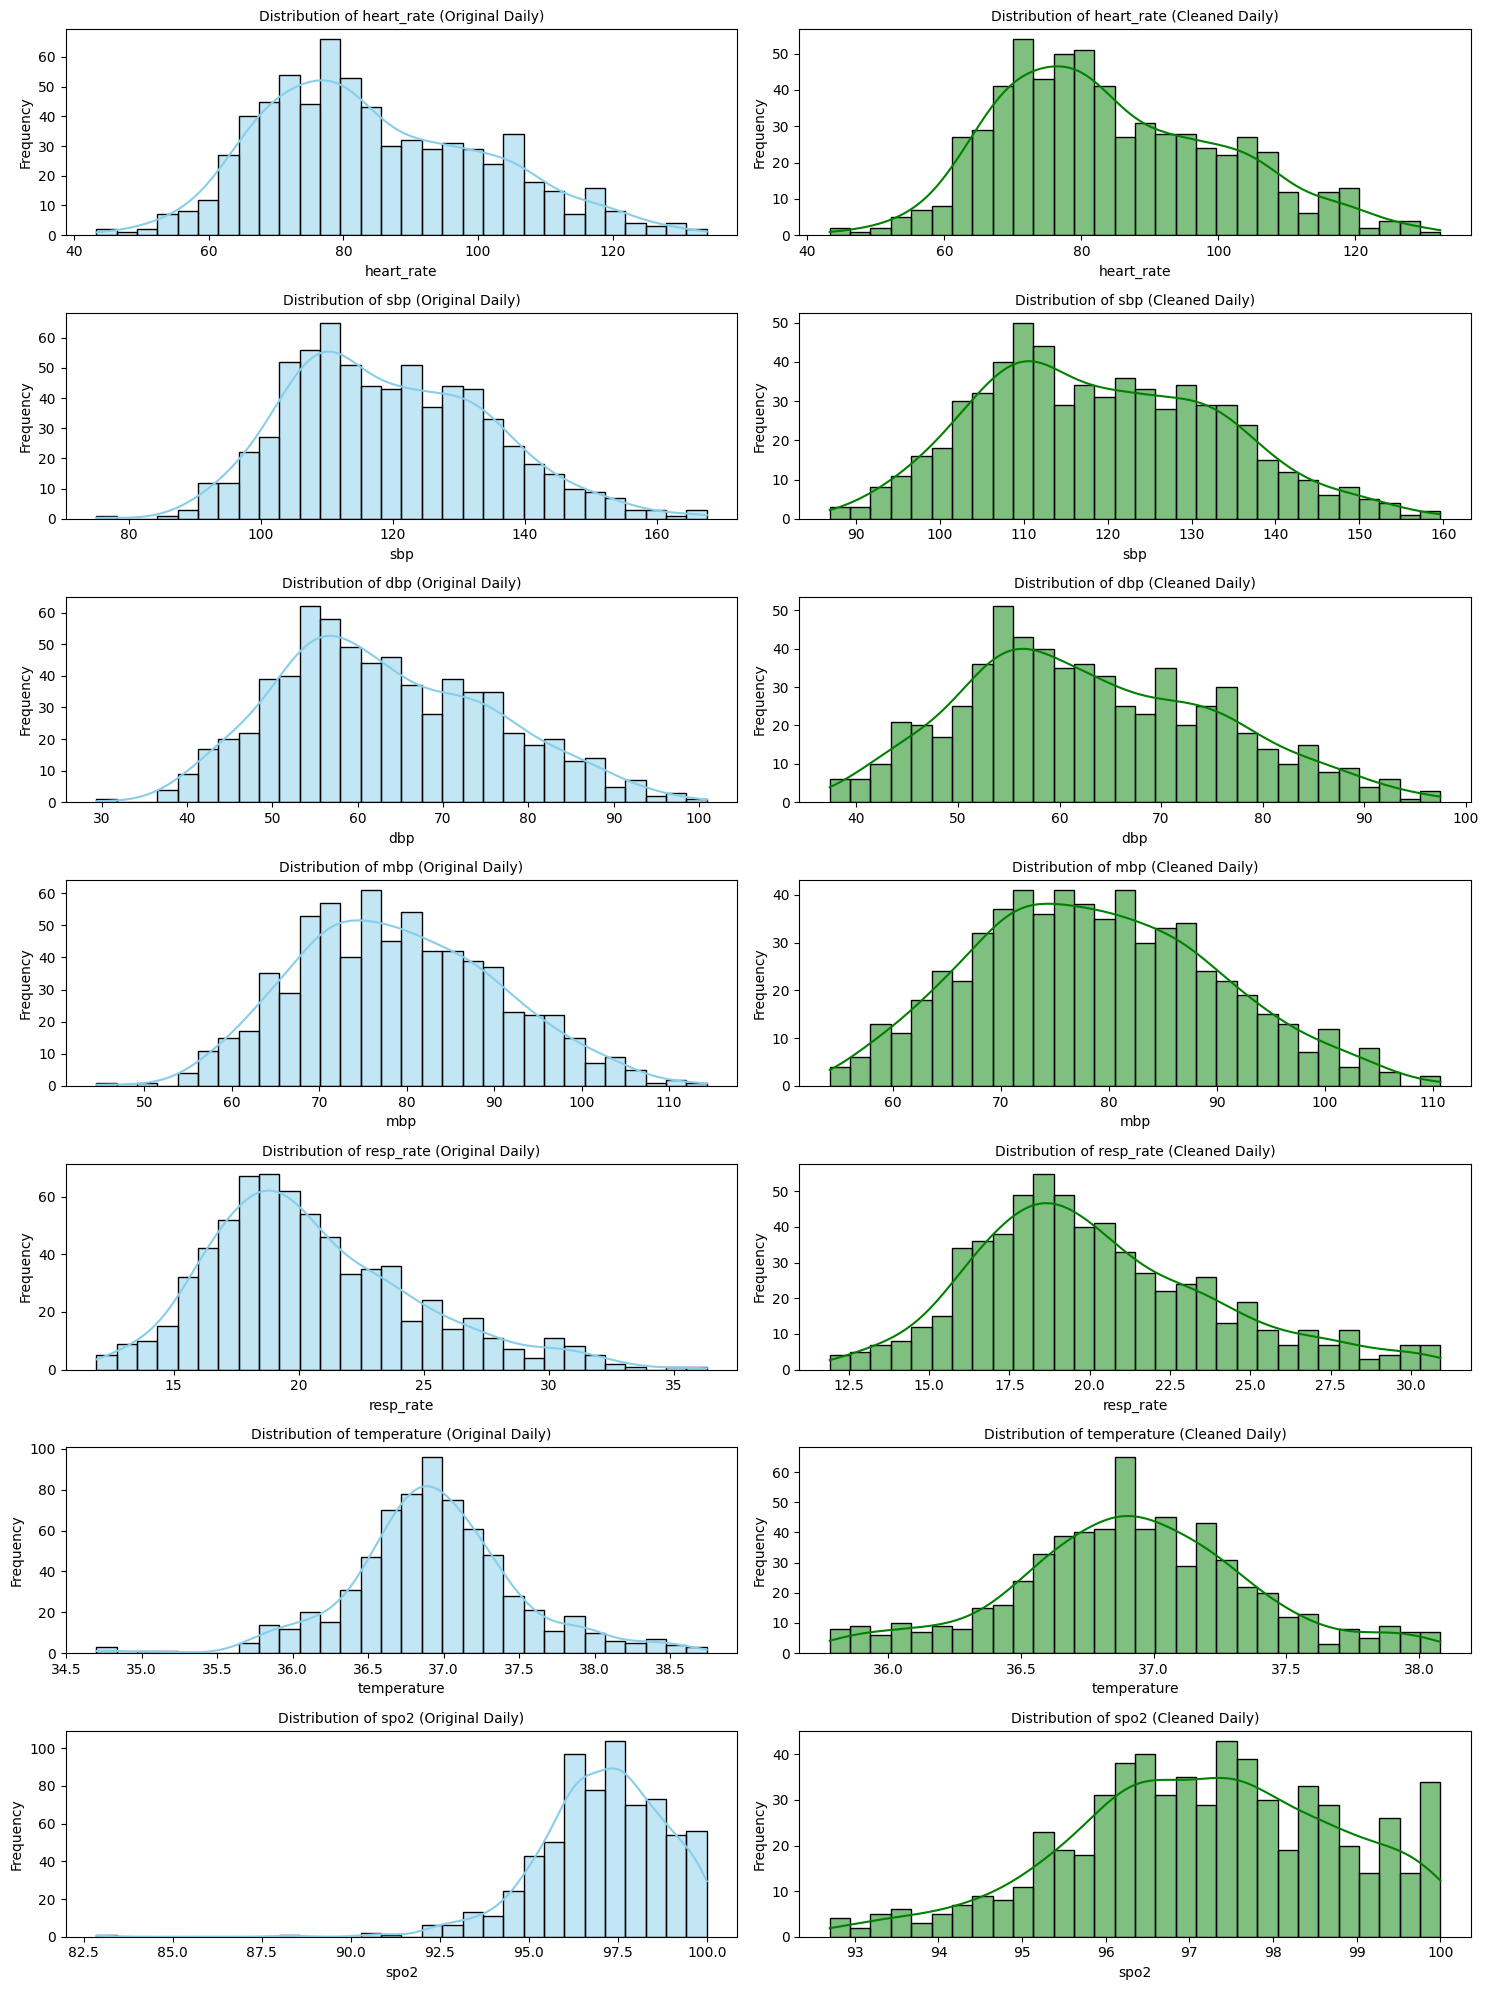

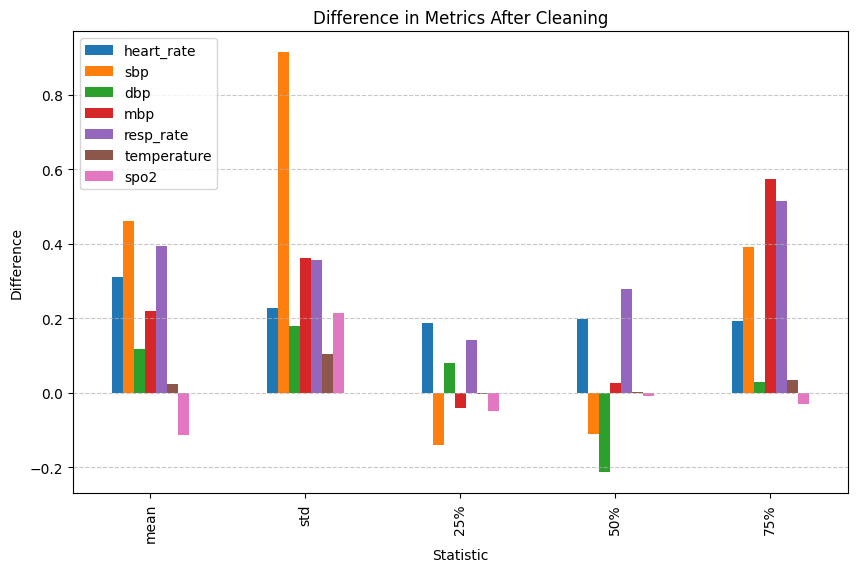

In [46]:

compare_distributions(daily_vitals, daily_vitals_cleaned, vital_cols, title_prefix="Daily")
# compare_distributions(weekly_vitals, weekly_vitals_cleaned, vital_cols, title_prefix="Weekly")
# compare_distributions(monthly_vitals, monthly_vitals_cleaned, vital_cols, title_prefix="Monthly")